In [1]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

In [2]:
import sys
sys.path.append('/home/TomKerby/Research/lit_review/configs')
from new_llm_config import config

sys.path.append('/home/TomKerby/Research/lit_review/lit_review')
import utils
from agent.agent_tools import SearchNeo4jVectorTool
import rag_utils as rag

from langchain_neo4j import Neo4jVector

kg = utils.load_kg(config)
# llm_adapter = rag.get_llm(config)
emb_adapter = rag.get_embeddings(config)

custom_query = """
MATCH (c:Chunk)
WITH DISTINCT c, vector.similarity.cosine(c.textEmbedding, $embedding) AS score
ORDER BY score DESC LIMIT $k
RETURN c.text AS text, score, {source: c.source, chunkId: c.chunkId} AS metadata
"""

chunk_vector = Neo4jVector.from_existing_index(
    emb_adapter.embeddings,
    graph=kg, 
    index_name=config["rag"]["index_name"],
    embedding_node_property=config["rag"]["embedding_node_property"],
    text_node_property=config["rag"]["text_node_property"],
    retrieval_query=custom_query,
)

tool = SearchNeo4jVectorTool(vector_db=chunk_vector)

In [3]:
from langchain_ollama import ChatOllama

llm_config = config['llm']

model = ChatOllama(
    model=llm_config["model_id"],
    num_ctx=llm_config.get("num_ctx", 32768),
    num_predict=llm_config.get("num_predict", 4096),
    temperature=llm_config.get("temperature", 0.5)
)

prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

from lit_review.langgraph_agent import agent

db_path = "./langgraph_agent.db"
memory = agent.load_memory(db_path, async_run=True)
abot = agent.Agent(model, [tool], system=prompt, checkpointer=memory)

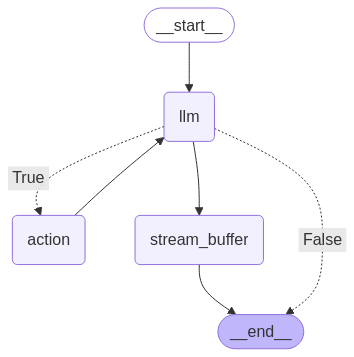

In [4]:
from IPython.display import Image, display

try:
    display(Image(abot.graph.get_graph().draw_mermaid_png()))
except:
    pass

In [5]:
thread = {"configurable": {"thread_id": '1'}}
inputs = {'messages': [HumanMessage(content="Please give a thorough and comprehensive list of some of the ways that the structure of a latent space in a diffusion model can be leveraged to help control the generation process?")]}

async for chunk_msg, metadata in abot.graph.astream(inputs, thread, stream_mode="messages"):
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

Received chunk: content='' additional_kwargs={} response_metadata={} id='run-b41afdc3-5b4a-4c86-887d-7ddeb2cb1bd5' tool_calls=[{'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent space structure control in diffusion models'}, 'id': '55069cda-0dca-484a-bd41-1f7e1935f486', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 10, "question": "latent space structure control in diffusion models"}', 'id': '55069cda-0dca-484a-bd41-1f7e1935f486', 'index': None, 'type': 'tool_call_chunk'}]



metadata: 
{'thread_id': '1', 'langgraph_step': 1, 'langgraph_node': 'llm', 'langgraph_triggers': ['start:llm'], 'langgraph_path': ('__pregel_pull', 'llm'), 'langgraph_checkpoint_ns': 'llm:212da004-ea9d-89f0-228a-a83435665dd6', 'checkpoint_ns': 'llm:212da004-ea9d-89f0-228a-a83435665dd6', 'ls_provider': 'ollama', 'ls_model_name': 'llama3.3', 'ls_model_type': 'chat', 'ls_temperature': 0.5}


Calling: {'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent space

In [6]:
thread = {"configurable": {"thread_id": '2'}}
messages = [HumanMessage(content="Please give a thorough and comprehensive list of some of the ways that the structure of a latent space in a diffusion model can be leveraged to help control the generation process?")]

await agent.run_agent(abot, messages, thread)

# final_state = await abot.graph.get_state(thread)
import asyncio
final_state = await asyncio.to_thread(abot.graph.get_state, thread)
final_message = final_state.values['messages'][-1].pretty_print()


Received chunk: content='' additional_kwargs={} response_metadata={} id='run-1798d18e-0cbf-40ec-8b23-278b0522775b' tool_calls=[{'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent space structure control in diffusion models'}, 'id': '728866ff-79f5-4b66-86f2-dd6fb448ae61', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 10, "question": "latent space structure control in diffusion models"}', 'id': '728866ff-79f5-4b66-86f2-dd6fb448ae61', 'index': None, 'type': 'tool_call_chunk'}]
Calling: {'name': 'search_chunks', 'args': {'k': 10, 'question': 'latent space structure control in diffusion models'}, 'id': '728866ff-79f5-4b66-86f2-dd6fb448ae61', 'type': 'tool_call'}
Received chunk: content='The structure of a latent space in a diffusion model can be leveraged to help control the generation process in several ways:\n\n1. **Semantic Latent Space**: The latent space can be analyzed from a geometrical perspective to understand its properties and discov

In [7]:
thread = {"configurable": {"thread_id": '1'}}
messages = [HumanMessage(content="Can you discuss item number 2 in more depth?")]
await agent.run_agent(abot, messages, thread)

# final_state = abot.graph.get_state(thread)
final_state = await asyncio.to_thread(abot.graph.get_state, thread)
final_message = final_state.values['messages'][-1].pretty_print()

Received chunk: content='' additional_kwargs={} response_metadata={} id='run-ca3cb0f3-c61b-4446-85f2-9672d2adc51a' tool_calls=[{'name': 'search_chunks', 'args': {'k': 10, 'question': 'Discuss item number 2 in more depth'}, 'id': '069934f5-d2f0-4371-bdfb-998ec43b2718', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 10, "question": "Discuss item number 2 in more depth"}', 'id': '069934f5-d2f0-4371-bdfb-998ec43b2718', 'index': None, 'type': 'tool_call_chunk'}]
Calling: {'name': 'search_chunks', 'args': {'k': 10, 'question': 'Discuss item number 2 in more depth'}, 'id': '069934f5-d2f0-4371-bdfb-998ec43b2718', 'type': 'tool_call'}
Received chunk: content='The second item, "Semantic Latent Space", refers to a latent space that can be discovered in pretrained diffusion models, which allows for versatile editing and quality boosting by quantifiable measures.\n\nIn more depth, the semantic latent space is a representation of the input data in a lower-dimensiona

In [8]:
thread = {"configurable": {"thread_id": '3'}}
messages = [HumanMessage(content="Who wrote the paper titled: Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models")]
# async for event in abot.graph.astream({"messages":messages,}, thread, stream_mode="updates"):
#     pass
await agent.run_agent(abot, messages, thread)
# abot.graph.get_state(thread).values['messages'][-1].pretty_print()

final_state = await asyncio.to_thread(abot.graph.get_state, thread)
final_message = final_state.values['messages'][-1].pretty_print()

Received chunk: content='' additional_kwargs={} response_metadata={} id='run-a95cda73-7512-4e82-87f3-2012a6d6dc39' tool_calls=[{'name': 'search_chunks', 'args': {'k': 5, 'question': 'Who wrote the paper titled: Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models'}, 'id': '0e5e9b1b-8f0d-4fc6-86aa-586ca8cebe0d', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 5, "question": "Who wrote the paper titled: Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models"}', 'id': '0e5e9b1b-8f0d-4fc6-86aa-586ca8cebe0d', 'index': None, 'type': 'tool_call_chunk'}]
Calling: {'name': 'search_chunks', 'args': {'k': 5, 'question': 'Who wrote the paper titled: Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models'}, 'id': '0e5e9b1b-8f0d-4fc6-86aa-586ca8cebe0d', 'type': 'tool_call'}
Received chunk: content='The paper titled "Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models" was written by Jiayi Guo, Xingqian Xu, Yifa

In [9]:
thread = {"configurable": {"thread_id": '3'}}
messages = [HumanMessage(content="How would you summarize the paper in 4 sentences?")]
# async for event in abot.graph.astream({"messages":messages,}, thread, stream_mode="updates"):
#     pass
await agent.run_agent(abot, messages, thread)
# abot.graph.get_state(thread).values['messages'][-1].pretty_print()
final_state = await asyncio.to_thread(abot.graph.get_state, thread)
final_message = final_state.values['messages'][-1].pretty_print()

Received chunk: content='' additional_kwargs={} response_metadata={} id='run-78cfd0c4-f6ec-4c4b-87ec-a836fb355543' tool_calls=[{'name': 'search_chunks', 'args': {'k': 4, 'question': 'Summarize the paper Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models in 4 sentences'}, 'id': '30863c4b-bbcb-4a87-a020-bccbedddc219', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'search_chunks', 'args': '{"k": 4, "question": "Summarize the paper Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models in 4 sentences"}', 'id': '30863c4b-bbcb-4a87-a020-bccbedddc219', 'index': None, 'type': 'tool_call_chunk'}]
Calling: {'name': 'search_chunks', 'args': {'k': 4, 'question': 'Summarize the paper Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models in 4 sentences'}, 'id': '30863c4b-bbcb-4a87-a020-bccbedddc219', 'type': 'tool_call'}
Received chunk: content='The paper "Smooth Diffusion: Crafting Smooth Latent Spaces in Diffusion Models" introduces a novel diffusion 